# Fake News Detector & Summarizer for Students

This notebook implements an AI solution to analyze news articles, assess their credibility (Fake vs Real), and provide concise summaries. This tool is designed to help students differentiate between reliable and fake information.

## Objectives
1.  **Data Loading & Preprocessing**: Load `Fake.csv` and `True.csv`, clean the data, and prepare it for training.
2.  **Fake News Detection**: Train a machine learning model (PassiveAggressiveClassifier) to classify news as Real or Fake.
3.  **Summarization**: Integrate a pre-trained Transformer model to generate trustworthy summaries of the articles.

## 1. Import Libraries

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from transformers import pipeline
import re
import string

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

## 2. Load and Inspect Data
We will load the `Fake.csv` and `True.csv` datasets located in the current directory.

In [19]:
# Load datasets
try:
    fake_df = pd.read_csv('Fake.csv')
    true_df = pd.read_csv('True.csv')
    print("Datasets loaded successfully.")
except FileNotFoundError:
    print("Error: CSV files not found. Please ensure 'Fake.csv' and 'True.csv' are in the same directory.")

# Add labels: 0 for Fake, 1 for True
fake_df['label'] = 0
true_df['label'] = 1

# Display shapes
print(f"Fake News Shape: {fake_df.shape}")
print(f"True News Shape: {true_df.shape}")

Datasets loaded successfully.
Fake News Shape: (23481, 5)
True News Shape: (21417, 5)


In [20]:
# Inspect first few rows
fake_df.head(3)

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0


In [21]:
true_df.head(3)

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1


## 3. Data Preprocessing
Combine the datasets, handle missing values, and clean the text content.

In [22]:
# Combine dataframes
df = pd.concat([fake_df, true_df], axis=0)

# Shuffle the dataset
df = df.sample(frac=1).reset_index(drop=True)

# Check for null values
print("Null values:\n", df.isnull().sum())

# Drop rows with missing text (if any)
df.dropna(subset=['text'], inplace=True)

df.head()

Null values:
 title      0
text       0
subject    0
date       0
label      0
dtype: int64


,title,text,subject,date,label
0,"Obama LIES To French Reporter, America “One Of...",Barack Hussein Obama has been laser focused on...,left-news,"Mar 1, 2016",0
1,France's Sapin says Brexit would affect London...,LONDON (Reuters) - London’s status as a global...,politicsNews,"May 12, 2016",1
2,ARROGANT JOHN KERRY: Trump Administration “wil...,JOHN KERRY: We ll have injured our own credibi...,politics,"Jan 18, 2017",0
3,‘The Lord’ Told A Trump-Loving Tow Truck Driv...,"Shupee Max Towing in Traveler s Rest, South Ca...",News,"May 5, 2016",0
4,Conservatives back latest U.S. healthcare bill...,WASHINGTON (Reuters) - The conservative House ...,politicsNews,"April 26, 2017",1


### Text Cleaning Function
We need to remove URLs, special characters, and punctuation to ensure the model focuses on the words.

In [23]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub('https?://\S+|www\.\S+', '', text) # Remove URLs
    text = re.sub('\\[.*?\]', '', text) # Remove text in brackets
    text = re.sub('<.*?>+', '', text) # Remove HTML tags
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) # Remove punctuation
    text = re.sub('\n', '', text) # Remove newlines
    text = re.sub('\w*\d\w*', '', text) # Remove words containing numbers
    return text

# Apply cleaning to a new column 'cleaned_content'
# Using 'text' column primarily, but you could combine 'title' + 'text'
df['cleaned_content'] = df['text'].apply(clean_text)

print("Text cleaning complete.")

Error while downloading from https://huggingface.co/sshleifer/distilbart-cnn-12-6/resolve/refs%2Fpr%2F29/model.safetensors: HTTPSConnectionPool(host='cas-bridge.xethub.hf.co', port=443): Read timed out.
Trying to resume download...


Text cleaning complete.


## 4. Feature Extraction & Model Training
We will use TF-IDF (Term Frequency-Inverse Document Frequency) to convert text into numerical vectors and train a PassiveAggressiveClassifier, which is effective for text classification.

In [24]:
# Split Data
X = df['cleaned_content']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorization
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

# Train Model
pac = PassiveAggressiveClassifier(max_iter=50)
pac.fit(tfidf_train, y_train)

# Evaluate
y_pred = pac.predict(tfidf_test)
score = accuracy_score(y_test, y_pred)
print(f'Accuracy: {round(score*100,2)}%')

Accuracy: 99.47%


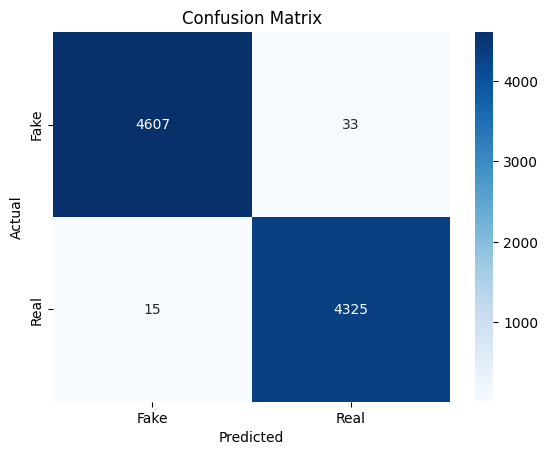

In [25]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

## 5. Integrating Summarization
We will use HuggingFace's `transformers` library to load a summarization pipeline. This will allow us to condense identifying truthful news articles.

In [26]:
# Initialize Summarizer (using a lightweight model for efficiency)
# Note: First run will download the model (~1GB)
summarizer = pipeline("summarization", model="sshleifer/distilbart-cnn-12-6")

def summarize_article(text):
    # Max input length for this model is usually 1024 tokens. Truncate if necessary.
    if len(text) > 3000: # Rough char limit to stay safe
        text = text[:3000]
    
    summary = summarizer(text, max_length=130, min_length=30, do_sample=False)
    return summary[0]['summary_text']

Device set to use cpu


## 6. Fake News Detector Application
Combine the classifier and summarizer into a single function for students to use.

In [27]:
def analyze_news_article(article_text):
    # 1. Clean and Predict
    cleaned = clean_text(article_text)
    vec = tfidf_vectorizer.transform([cleaned])
    prediction = pac.predict(vec)
    
    result = "FAKE News" if prediction[0] == 0 else "REAL News"
    
    print(f"--- Analysis Result ---")
    print(f"Verdict: {result}")
    
    # 2. Summarize
    print("\nGenerating Summary...")
    try:
        summary = summarize_article(article_text)
        print(f"Summary: {summary}")
    except Exception as e:
        print(f"Could not generate summary: {e}")

### Test the Application
Paste a news article text below to test the system.

In [28]:
# Example Usage
sample_text = """
WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018.
"""
# You can replace sample_text with any article body
analyze_news_article(sample_text)

Your max_length is set to 130, but your input_length is only 62. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=31)


--- Analysis Result ---
Verdict: REAL News

Generating Summary...
Summary:  The head of a conservative Republican faction in the U.S. Congress called himself a “fiscal conservative” on Sunday . He urged budget restraint in 2018 .


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
